<a href="https://colab.research.google.com/github/509981/kerasin/blob/main/Kerasin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Поиск оптимальной модели нейросети с применением генетического алгоритма

Применяется класс который способен генерировать случайным образом модели совместимые с фреймворком keras. Проводить операции кроссовера и мутации над ними.


`Версия 0.95 от 3 августа 2021 г.`

---

**Автор:** Утенков Дмитрий Владимирович
* **e-mail:** 509981@gmail.com 
* **Тел:**   +7-908-440-9981

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
from copy import deepcopy

from tensorflow.keras.layers import Dense,Dropout,Input,concatenate,BatchNormalization,Conv2D,MaxPooling2D
from tensorflow.keras.layers import LSTM,Embedding,Reshape,GaussianNoise
from tensorflow.keras.layers import Conv1D, SpatialDropout1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D,Flatten,LSTM
from tensorflow.keras.models import Model,clone_model
from tensorflow.keras import utils
import keras.backend as K

import matplotlib.pyplot as plt

In [ ]:
# Генерация нециклического орграфа c одним выходом и 1-4 входами
class neuro_graph:
  def __init__(self):
    self.edjes = list()
    self.n_in = 1
  # Количество вершин графа
  def nNodes(self):
    ret=0
    for edje in self.edjes:
      ret = max(ret,edje[0],edje[1])
    return ret

  # Добавить ребро
  def addEdje(self,node_from,node_to):
    self.edjes.append((node_from,node_to))
    
  # Сгенерировать граф
  def generate(self,maxnodes,n_in = 1):
    self.clear()
    is_cycle = True
    while(is_cycle):
      self.clear()
      self.__generate_subnet__(5,maxnodes,n_in,0)
      is_cycle = self.__renumerate__()

  # Очистить граф
  def clear(self):
    self.edjes = []

  # Функция генерации орграфа с одним выходом и n_in входов
  # не рекомендуется более 5 вершин из-за появления циклов
  # n - количество вершин
  # n_in - количество входов
  def __generate_graph__(self,n,n_in = 1):
    self.n_in=n_in
    # Вероятностный список количества входящих в вершину ребер
    nodes_in_list = [1,1,1,1,1,1,1,1,2]
    # Создаем матрицу инцидентности
    graph = np.zeros((n,n))
    # Проходим матрицу построчно из конца к началу
    for i in range(n-1,n_in-1,-1):
      # Определяем количество входящих ребер nodes_in в вершину i
      nodes_in = nodes_in_list[random.randint(0,len(nodes_in_list)-1)]
      # Создаем список возможных ребер node_area
      # убираем последний столбец тк не может получать ребро от out node
      node_area = np.arange(0,n-1)  
      if i<n: 
        node_area = np.setdiff1d(node_area,i) # Не может ссылаться на себя
        # node не может получить вход от node который получил вход от него
        for node in node_area:
          if graph[node][i] > 0: 
            node_area = np.setdiff1d(node_area,node)
            
      if i==n-1: 
        node_area = np.setdiff1d(node_area,np.arange(n_in))  #Нельзя связывать вход и выход напрямую

      # Предотвращение висячих нодов 
      # исключим из nodes_in все заполненые колонки если дело близко к концу
      # для этого соберем ноды имеющие входы в filled_cols
      filled_cols = []
      for j in range(n-n_in):
        if np.sum(graph[:,j])>0: filled_cols.append(j)
      # Исключим из списка возможных вершин те которуе уже имеют вершину в пользу висячих 
      if n-1-len(filled_cols)>=i: 
        node_area = np.setdiff1d(node_area,filled_cols)
        #if len(node_area)==0: node_area = np.array(filled_cols)
      if len(node_area)==0:
        #  Если после этого вариантов не осталось и нод остался висящим 
        # соединяем его входу
        graph[i][0] = 1
        #node_area = np.array(filled_cols)
      # Проследим чтобы требуемое количество нодов не привысило кол-во вариантов
      nodes_in = min(nodes_in,node_area.shape[0])
      # Выбираем входящие ноды из оставшихся
      list_nodes = random.sample(list(node_area),nodes_in)
      # Делаем отметку в матрице инцидентности
      for node in list_nodes:
        graph[i][node] = 1
    # Финальная проверка висячих строк
    # Если находим, замыкаем на out node
    for j in range(0,n-1):
      if np.sum(graph[:,j])==0: 
          graph[n-1][j] = 1
    return graph    

  # Рекурсивная функция генерации орграфа путем развертки 
  # случайного ребра на вложеный орграф
  #
  # nodes - количество вершин на итерации
  # maxnodes - максимальное количество вершин графа
  # n_in - кол-во входных вершин(только для 1 итерации, для остальных=1)
  # start_node = номер первого нода итерации
  def __generate_subnet__(self,nodes,maxnodes,n_in = 1,start_node=0):
    assert n_in < nodes # Количество входов должно быть меньше чем количество вершин
    # Генерируем орграф с матрицей смежности MAJ
    MAJ = self.__generate_graph__(nodes,n_in)
    for node_to in range(nodes):
      for node_from in range(nodes):
        # Находим ребро в матрице смежности
        if MAJ[node_to][node_from]>0:
          if(( (node_from < n_in and node_to==nodes-1) # Если вход напрямую соединенс выходом
            or random.random()>0.8)               # или вмешивается случай
            and start_node+nodes<maxnodes):       #и количество вершин не превышает лимит
            # ребро разворачиваем в подсеть с 5 вершинами максимум.
            subnodes=min(5,maxnodes-start_node-nodes)
            # Соединяем подсеть с вершинами разорваного ребра
            self.edjes.append((start_node+node_from, start_node+nodes))
            self.edjes.append((start_node+subnodes+nodes-1, start_node+node_to))
            # Только сеть первой итерации может иметь несколько входов
            # поэтому далее указываем явно n_in=1
            self.__generate_subnet__(subnodes,maxnodes,1,start_node+nodes)          
          else:
            # Сохраняем ребро из матрицы инцидентности
            self.edjes.append((start_node+node_from,start_node+node_to))
    #print(MAJ)
    return 

  #   Перенумеровать вершины в порядке построения:т.е. не одна вершина не будет собрана
  # пока не будут собраны входящие в нее 
  # Это необходимо для удобного изменения входящих дуг и кросовера
  def __renumerate__(self):
    num_nodes = self.nNodes()
    node_done = set(range(self.n_in))
    skiped_layer = True
    connectors_in = []
    n_con_done = 0
    new_idx = self.n_in
    trans = {a:a for a in range(num_nodes)}
    while(skiped_layer):
      #print('--------------')
      skiped_layer = False
      if n_con_done > 1:
        print('Err: граф цикличен')
        return True
      n_con_done += 1

      for idx in range(self.n_in,num_nodes+1):
        if not idx in node_done:
          
          skiped_layer = True
          unfill_ins = False
          list_in = [x[0] for x in self.edjes if x[1] == idx]#[edjes[1]==idx for len(edjes)]
          #print(idx,list_in)
          for in_node in list_in:
            #print(' - ',in_node)
            if not in_node in node_done:
              #print(' - ',in_node,'пуст, пропускаем')
              unfill_ins = True
              break
            #else:
              #print(' - ',in_node,'done')
          if unfill_ins: continue
          node_done.add(idx)
          trans[idx]=new_idx
          #print(idx,' слой определен как ',new_idx)
          new_idx += 1
          n_con_done = 0
          #print(trans)
    new_edjes = []
    trans[0]=0
    for edje in self.edjes:
      #new_node_from = [x[1] for x in trans if x[0] == edje[0]]
      #new_node_to = [x[1] for x in trans if x[0] == edje[1]]
      #print(new_node_from,new_node_to,edje)
      new_edjes.append((trans[edje[0]],trans[edje[1]]))
    self.edjes = new_edjes
    return False


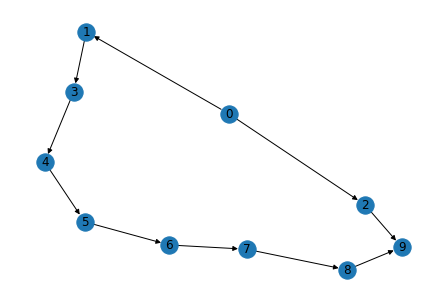

In [ ]:
G = neuro_graph()
G.generate(20,1)
V=nx.DiGraph()
V.add_edges_from(G.edjes)
nx.draw(V, pos=nx.spring_layout(V),with_labels =True)
for cycle in nx.simple_cycles(V):
  print(cycle,' - найден цикл!') 
#G.renumerate()

In [ ]:
GUnknown, GInput, GMain, GExt  = range(4)
#Список основных типов слоев содержит правильные названия их классов и частоту
types_list = ['Dense', 'Dense', 'Conv2D', 'Conv2D','Conv1D','Conv1D',\
                 'MaxPooling1D','MaxPooling2D','LSTM','GaussianNoise']

#ext_types_list = ['Flatten','concatenate','Dropout','BatchNormalization']                 


# типы активации
type_activations = ['linear','relu', 'elu','tanh','softmax','sigmoid', 'selu']

# Класс гена нейросети 
class gen(object):
  def __init__(self,layer_idx, sublayer_idx, block_name, var_name, value):
    self.layer_idx = layer_idx  # Номер слоя
    self.sublayer_idx = sublayer_idx  # Номер вложеннного слоя
    self.name = block_name  # Имя типа слоя из types_list
    self.var_name = var_name  # Имя параметра слоя керас
    self.value = value  # Значение параметра слоя керас
    self.changed = False  # Признак измененного значения

  # Получить строку представления гена
  def get(self):
    return ""+str(self.layer_idx)+"."+ str(self.sublayer_idx)+" "+self.name+ ": "+\
    self.var_name +"="+ str(self.value)

  # Изменяем параметр генома случайным способом
  # arg - словарь аргументов для проверки на взамоисключающее сочетание параметров
  def mutate(self):
    self.changed = True
    if self.var_name == 'name': return 2 # Изменение типа слоя
    elif 'Concatenate' == self.name and self.var_name == 'inbound_layers': return 3 # Изменение связи
    #elif 'concat' in self.name: return 3 # Изменение связи
    if self.name == 'InputLayer': return 0 # Игнор
    elif self.var_name == 'units': self.value=2**random.randint(2,10)
    elif self.var_name == 'filters': 
      self.value=2**random.randint(2,8)
      # Conv1D:The number of filters must be evenly divisible by the number of groups. Received: groups=3, filters=16
      '''
      try:
        gr = arg['groups']
        while True:
          flt=2**random.randint(2,8)
          if flt % gr == 0: 
            self.value = flt / gr
            break       
      except:
        self.value = 1
      #print("f!!!",gr,flt,self.value)
      '''  
      #self.value=2**random.randint(2,8)
    elif self.var_name == 'activation': self.value = type_activations[random.randint(0,len(type_activations)-1)]
    elif self.var_name == 'use_bias': self.value = (random.random() > .3)
    elif self.var_name == 'scale' and 'batch_n' in str.lower(self.name): self.value = (random.random() > .3)
    elif self.var_name == 'center' and 'batch_n' in str.lower(self.name): self.value = (random.random() > .3)
    elif 'regularizer' in self.var_name: self.value = random.sample([None,None,None,None,'l1','l2','l1_l2'],1)[0] #tf.keras.regularizers.l2(0.01)
    elif self.var_name == 'rate' and 'dropout' in str.lower(self.name): self.value=random.random()*.5
    elif 'dropout' in str.lower(self.var_name): self.value=random.random()*.5 #LSTM
    elif self.var_name == 'stddev': self.value=random.random()*.5 # Noise
    elif self.var_name == 'go_backwards': self.value = (random.random() < .3) #LSTM
    elif self.var_name == 'unit_forget_bias': self.value = (random.random() > .3) #LSTM
    elif self.var_name == 'unroll': self.value = (random.random() < .3) #LSTM
    elif self.var_name == 'stateful': self.value = (random.random() < .3) #LSTM
    elif self.var_name == 'pool_size': self.value = random.randint(2,4) #MaxPooling
    elif self.var_name == 'kernel_size': 
      winsize = random.randint(3,7)
      if '1D' in self.name: self.value = (winsize,)
      elif '2D' in self.name: self.value = (winsize,winsize)
      elif '3D' in self.name: self.value = (winsize,winsize,winsize)
    elif self.var_name == 'strides': 
      val = random.randint(1,3)
      if '1D' in self.name: self.value = (val,)
      elif '2D' in self.name: self.value = (val,val)
      elif '3D' in self.name: self.value = (val,val,val)
    elif self.var_name == 'padding':
      self.value=random.sample(['valid','same'],1)[0]
    else:
      # Список неизменяемых параметров
      if self.var_name == 'dilation_rate': pass
        #  В настоящее время указание любого dilation_rateзначения! = 1 несовместимо с указанием любого значения шага! = 1.'
      elif self.var_name == 'groups': 
        self.value = 1
        # Conv1D:The number of filters must be evenly divisible by the number of groups. Received: groups=3, filters=16
        '''
        The number of input channels must be evenly divisible by the number of groups. Received groups=8.0, but the input has 28 channels (full input shape is (None, 28, 28))
        try:
          flt = arg['filters']
          while True:
            gr=random.randint(1,4)
            if flt % gr == 0: 
              self.value = flt / gr
              break       
        except:
            self.value = 1
        print("!!!",gr,flt,self.value)
        '''
      # Эти параметры обычно нет смысла менять
      elif 'constraint' in self.var_name: pass
      elif self.var_name == 'dtype': pass
      elif self.var_name == 'return_sequences': pass
      elif self.var_name == 'seed': pass
      elif self.var_name == 'trainable': pass
      elif self.var_name == 'data_format': pass
      elif self.var_name == 'axis': self.value = -1
      elif self.var_name == 'ragged': pass  # Input
      elif self.var_name == 'sparse': pass  # Input
      elif self.var_name == 'batch_input_shape': pass  # Input
      # Разобраться позже
      elif self.var_name == 'inbound_layers': pass # return 3 # Изменение связи не 'Concatenate' == self.name
      elif self.var_name == 'momentum': pass  # BatchNorm
      elif self.var_name == 'epsilon': pass  # BatchNorm
      elif self.var_name == 'scale': pass  # BatchNorm
      elif self.var_name == 'noise_shape': pass  # Dropout
      elif self.var_name == 'implementation': pass  # lstm
      elif self.var_name == 'time_major': pass  # lstm
      elif self.var_name == 'return_state': pass  # lstm
      elif self.var_name == 'recurrent_activation': pass  # lstm
      else:
        print('пропущено:',self.get())
      return 0

    return 1
  
  # Копирование гена
  def copy(self):
    clone = deepcopy(self)
    #clone._b = some_op(clone._b)
    return clone


# Класс слоя
class gen_layer(object):
  def __init__(self):
    self.connector = None # Выходной тензор keras f api
    self.sublayer = list()  # Список вложенных ссылок на слой керас
    self.genotype = list()  # Геном(хромосома) слоя

    #Свойства топологии
    self.list_in = list()         # Список входов
    self.list_out = list()        # Список выходов
    # Свойства нейрона
    self.neurotype = GUnknown  # Тип слоя
    self.shape_out = ()        # Форма на выходе
    self.data = None  # Любые данные к слою

  '''
  def copy(self):
    clone = copy.deepcopy(self)
    #clone._b = some_op(clone._b)
    return clone


  def __deepcopy__(self, memo): # memo is a dict of id's to copies
    id_self = id(self)        # memoization avoids unnecesary recursion
    _copy = memo.get(id_self)
    if _copy is None:
       #_copy = type(self)(
         #deepcopy(self.layers, memo), 
         #deepcopy(self.b, memo))
         memo[id_self] = _copy 
    return _copy

  def __deepcopy__(self, memo):
    print('deep copying layers...') 
    clone = type(self)()
    memo[id(self)] = clone
    clone.list_in = deepcopy(self.list_in, memo)  
    clone.list_out = deepcopy(self.list_out, memo)  
    clone.sublayer = deepcopy(self.sublayer, memo)  
    clone.connector = deepcopy(self.connector, memo)  
    return clone  
  '''
  # Получить геном списком
  def getGenotype(self,mutable_only=True,changed_only=False): 
    if len(self.genotype) == 0:# and (not changed_only):
      print('Генотип не заполнен. Вызовите sequence()',self.connector)
      return []
      #self.sequence(0)
    lst = list()
    for l in self.genotype:
      if not changed_only or l.changed:
        if mutable_only:
          # Тестируем ген на изменчивость 
          cpy = l.copy()
          if cpy.mutate()==0: continue
        lst.append(l)
    return lst


  # Извлечь генотип из словаря параметров слоя get_config()
  def cfg_to_genotype(self,cfg, layer_idx = -1, sublayer_idx=0,layer_name=''):
    genotype = []
    for key, value in cfg.items():
      if not ('initializer' in key):
        genotype.append( gen( layer_idx, sublayer_idx, layer_name, key, value) )

    return genotype

  # Перевести генотип в словарь аргументов совместимых с слоем керас
  def genotype_to_cfg(self,genotype=None,cfg = None):
    if genotype == None: genotype = self.genotype
    if cfg == None: cfg = dict()
    for g in genotype:
      if g.var_name != 'inbound_layers':
        cfg[g.var_name] = g.value
    return cfg
  # Тест Неактивности слоя. Неактивный слой не имеет входа/выхода
  def IsInactiveLayer(self):
    return len(self.list_in)+len(self.list_out) == 0

  # Прочитать генотип из фенотипа(модели керас)
  def sequence(self,idx_layer):
    #print(len(self.sublayer)) 
    if self.connector == None: 
      print('нет слоя для сиквенции',self.list_in,self.list_out)
      assert not self.IsInactiveLayer() # Не пустой слой причина?
      return None    
    self.genotype.clear()
    for idx in range(len(self.sublayer)):
      layer = self.sublayer[idx]
      l_type = layer.__class__.__name__
      self.genotype.extend( self.cfg_to_genotype(layer.get_config(), idx_layer, idx ,l_type) )
      if 'Concat' in l_type or l_type in types_list:
        # Для главного слоя указываем входящие
        self.genotype.append( gen( idx_layer, idx, l_type, 'inbound_layers', self.list_in) )

    return self.genotype
  # Добавить слой в список
  def addLayer(self,layer):
    self.sublayer.append(layer)

  # Очистить слой от признаков фенотипа и топологии
  def clear(self): 
    self.list_in.clear()
    self.list_out.clear()
    self.connector = None
    self.sublayer.clear()
    #self.genotype.clear()

  # Тестирует является ли слой выходом
  def isOut(self): 
    return (len(self.list_out)==0 and len(self.list_in)>0)
  
  # Получить форму выходного тензора слоя
  def getShape(self):
    if self.connector == None: return None
    return self.connector.shape   
  # Количество входящих связей
  def NumConnectorIn(self): return len(self.list_in)
  # Количество исходящих связей
  def NumConnectorOut(self): return len(self.list_out)
  # Добавить Начальный слой
  def addConnectionIn(self,connector_id): 
    if not connector_id in self.list_in: self.list_in.append(connector_id)
  # Добавить Конечный слой
  def addConnectionOut(self,connector_id): 
    if not connector_id in self.list_out: self.list_out.append(connector_id)
  # Удалить Входящую связь
  def delConnectionIn(self,connector_id): 
    self.list_in.remove(connector_id)
  # Удалить Исходящую связь
  def delConnectionOut(self,connector_id): 
    self.list_out.remove(connector_id)
  # Установить тип слоя
  def SetNeuro(self,neurotype): self.neurotype = neurotype


  # Подбираем слой под входящую конфигурацию
  def suggestLayer(self,inbound_layers):
    if len(inbound_layers) == 0:
      return 'InputLayer'
    elif len(inbound_layers) > 1:
      return 'concatenate'
    else:
      shape_dim = len(inbound_layers[0].shape)-1
      layer_in_name = inbound_layers[0]._keras_history.layer.__class__.__name__

      while True:
        neurotype = random.sample(types_list,1)[0]
        #print(neurotype,layer_in_name) 
        if neurotype == 'Flatten' and shape_dim>1: break; # and layer_in != 'Flatten':
        elif neurotype == 'MaxPooling2D' and shape_dim==3: break
        elif neurotype == 'Conv2D' and shape_dim==3: break
        elif neurotype == 'MaxPooling1D' and shape_dim==2: break
        elif neurotype == 'Conv1D' and shape_dim>1: break
        elif neurotype == 'LSTM' and shape_dim==2: break
        elif neurotype == 'GaussianNoise' and random.random()<.4 and neurotype != layer_in_name: break
        elif neurotype == 'Dense': break
    return neurotype



  # Получаем образец набора параметров слоя
  def GetLayerArgs(self,neurotype):
    if neurotype == 'Dense':
      x = Dense(10)
    elif neurotype == 'concatenate':
      return dict()
    elif neurotype == 'Flatten':
      x = Flatten()
    elif neurotype == 'MaxPooling2D':
      x = MaxPooling2D()
    elif neurotype == 'Conv2D':
      x = Conv2D(10,1)
    elif neurotype == 'MaxPooling1D':
      x = MaxPooling1D()
    elif neurotype == 'Conv1D':
      x = Conv1D(10,1)
    elif neurotype == 'LSTM':
      x = LSTM(10)
    elif neurotype == 'GaussianNoise':
      x = GaussianNoise(.5)
    elif neurotype == 'Dropout':
      x = Dropout(.5)
    elif neurotype == 'BatchNormalization':
      x = BatchNormalization()
    else:
      print('недопустимый слой:',neurotype)
      assert False
    return x.get_config()

  # Создаем слой
  def create_layer(self,neurotype,conn_in = None,cfg=None):
    #print('попытка сборки слоя - ',neurotype)
    if neurotype == 'InputLayer':
        # Создаем Вх. слой только если он не существует Пересоздание не допустимо(?)
        assert self.connector == None
        x = Input(self.shape_out)
        self.addLayer(x._keras_history.layer)
        #self.genotype.clear()
        return x
    #assert x != None and cfg != None

      #elif neurotype == 'Embedding':
      #  x = Embedding(self.shape_out,2**random.randint(5,9))
    elif str.lower(neurotype) == 'concatenate':
      # Несколько входов - значит коннектор
      assert len(conn_in)>1
      #self.SetNeuro(GConcat)
      try:
        x = concatenate(conn_in)
        self.addLayer(x._keras_history.layer)
      except:
        print('ошибка конкатенации слоев')
        flate_connector = []
        for conn in conn_in:
          if len(conn.shape) == 2: 
            flate_connector.append(conn)
          else:
            x = Flatten()(conn)
            self.addLayer(x._keras_history.layer)
            flate_connector.append(x)
        try:        
          x = concatenate(flate_connector)
          self.addLayer(x._keras_history.layer)
        except:
          self.sublayer.clear()
          print('ошибка конкатенации слоев',self.getShape())
          return None
      return x
    try:
      #if True:
      x = conn_in[0]
      if neurotype == 'Dense':
        x = Dense.from_config(cfg)(x)
      elif neurotype == 'Flatten':
        x = Flatten.from_config(cfg)(x)
      elif neurotype == 'MaxPooling2D':
        x = MaxPooling2D.from_config(cfg)(x)
      elif neurotype == 'Conv2D':
        x = Conv2D.from_config(cfg)(x)
      elif neurotype == 'MaxPooling1D':
        x = MaxPooling1D.from_config(cfg)(x)
      elif neurotype == 'Conv1D':
        x = Conv1D.from_config(cfg)(x)
      elif neurotype == 'LSTM':
        x = LSTM.from_config(cfg)(x)
      elif neurotype == 'GaussianNoise':
        x = GaussianNoise.from_config(cfg)(x)
      elif neurotype == 'Dropout':
        x = Dropout.from_config(cfg)(x)
      elif neurotype == 'BatchNormalization':
        x = BatchNormalization.from_config(cfg)(x)
      else:
        print(neurotype,' - неописаный слой')
        return None  
      self.addLayer(x._keras_history.layer)
      
    except Exception as e:
      #except ValueError:
      print(neurotype,' - слой с входом',conn_in,'не собрался: '+str(e))
      print('Слой активен?:',not self.IsInactiveLayer())
      return None
    return x


  # Добавляем вспомогательные слои
  def create_extlayers(self,x):
    layer_in_name = x._keras_history.layer.__class__.__name__
    if layer_in_name == 'Dense':
      if random.random()>.6:
        print('сборка слоя - Dropout')
        arg = self.GetLayerArgs('Dropout')
        cfg = self.mutate(arg)
        x = self.create_layer('Dropout',[x],cfg)
      if random.random()>.6:
        print('сборка слоя - BatchNormalization')
        arg = self.GetLayerArgs('BatchNormalization')
        cfg = self.mutate(arg)
        x = self.create_layer('BatchNormalization',[x],cfg)
    return x

  # Проводим мутацию аргументов слоя без сохранения
  def mutate(self,arg):
    genotype = self.cfg_to_genotype(arg)
    #arg_to_verify = arg.copy()
    #assert len(genotype)>0
    for g in genotype:
      if g.var_name != 'name':        
        g.mutate()#arg_to_verify)
        #arg_to_verify[g.var_name] = g.value # Актуализируем данные для проверки непротиворечивости
    return self.genotype_to_cfg(genotype, arg)

  # Создаем слой случайно или из генотипа
  def build_layer(self,connectors_in):
    #if self.neurotype == GInput:
    if len(self.list_in) == 0:
      if self.connector == None:
        self.connector = self.create_layer('InputLayer')
      return self.connector
    #changed_gens = self.getChangedGens()
    changed_gens = [g for g in self.genotype if g.changed]
    #print(changed_gens,self.genotype)
    change_type = [g for g in changed_gens if g.var_name == 'name']
    #print('=====================',change_type)
    self.connector = None
    self.sublayer.clear() # !!! __del__ надо?
    if len(change_type)>0 or len(self.genotype)==0:
      # Требуется замена типа слоя или создание
      #self.sublayer.clear() # !!! __del__ надо?
      while(self.connector == None):
        layer_type = self.suggestLayer(connectors_in)
        arg = self.GetLayerArgs(layer_type)
        # Для случайного задания параметров нового слоя проводим мутацию всего генома слоя
        cfg = self.mutate(arg)
        # Создаем слой
        self.connector = self.create_layer(layer_type, connectors_in, cfg)
        #print('создание',layer_type,cfg)

      self.connector = self.create_extlayers(self.connector)
      #layers.deserialize(({'class_name': layer_type, 'config': arg})
    else:
      assert len(self.genotype)>0
      # Переформируем слой на основе генома
      if len(connectors_in)>1:
        self.connector = self.create_layer('concatenate', connectors_in)
      else:
        sublayer_idx = -1
        x = connectors_in[0]
        for idx in range(10):
          gens = [g for g in self.genotype  if g.sublayer_idx == idx and g.var_name != "inbound_layers"]
          if len(gens)==0: break
          cfg = self.genotype_to_cfg(gens)
          #layer_type = cfg['name']
          #print('замена',gens[0].name,cfg)
          x = self.create_layer(gens[0].name, [x], cfg)
        self.connector = x
    ''' 
    else:
      # Слой оставляем, меняем параметры
      save_sublayer = self.sublayer.copy()
      self.sublayer.clear()
      for idx in range(len(save_sublayer)):
        layer = save_sublayer[idx]
        arg = layer.get_config()
        layer_type = layer.__class__.__name__
        # Изменяем параметры слоя idx в соответствии с генотипом
        layer_gens = [g for g in changed_gens if g.sublayer_idx == idx]
        #if len(layer_gens)==0: continue # Генотип не меняет слой переходим к следующему
        for a in layer_gens:
          print('изменился ',a.get())
          arg[a.var_name] = a.value
        # Удаляем старый слой, создаем с новыми параметрами
        #layer.__del__()
        self.connector = self.create_layer(layer_type, connectors_in, arg)
    '''
    #self.genotype.clear()
    return self.connector
  

# Класс генотипированной сети керас
class gen_net(object):
  # кол-во попыток autocrossover()
  max_crossover_loop = 25

  def __init__(self,name):
    self.name = name
    self.description = ""
    # Слои сети
    self.layers = list()#[ gen_layer() for i in range(nodes) ]
    # Количество слоев Input
    self.nodes_in = 1
    # Слой выхода
    self.final_layer = gen_layer()
    # Керас модель
    self.model = None
    # Признак учета последовательности во входных данных
    self.is_sequence = False
    # Результат работы fit 
    self.hist = None
    # Оценка точности сети.Как правило loss. -1 если оценки не было
    self.score = -1
  
  '''
  def __deepcopy__(self, memo): # memo is a dict of id's to copies
        id_self = id(self)        # memoization avoids unnecesary recursion
        _copy = memo.get(id_self)
        if _copy is None:
            _copy = type(self)(
                deepcopy(self.layers, memo), 
                #deepcopy(self.b, memo))
            memo[id_self] = _copy 
        return _copy


  def __deepcopy__(self, memo):
    print('deep copying ...') 
    clone = type(self)()
    memo[id(self)] = clone
    clone.model = clone_model(self.model)
    clone.layers = deepcopy(self.layers, memo)  
    return clone
  '''
  # Копирование экземпляра класса
  def copy(self):
    #print('deep copying ...')    
    self.sequence()
    gn = self.getGenotype(False,False)
    clone = gen_net(self.name+' clone')
    clone.nodes_in = self.nodes_in
    clone.is_sequence = self.is_sequence
    clone.final_layer.shape_out = self.final_layer.shape_out
    clone.final_layer.data = self.final_layer.data
    clone.loadGenotype(gn)
    if clone.synthesis(): return clone
    print('Клонирование неудачно...')    
    return None

  
  #
  #   Методы работы с топологией
  #

  #   Добавить удалить связь между слоями True в случае успеха
  def reConnection(self,id_from_new,id_from,id_to):
    assert id_from_new < id_to
    assert id_from < id_to
    res = self.layers[id_to].delConnectionIn(id_from)
    res = self.layers[id_to].addConnectionIn(id_from_new)
    self.layers[id_from].delConnectionOut(id_to)
    self.layers[id_from_new].addConnectionOut(id_to)
    return False
  #   Добавить удалить связь между слоями True в случае успеха
  def delConnection(self,id_from,id_to):
    maxnode = max(id_from,id_to)
    assert maxnode<len(self.layers)
    res = self.layers[id_to].delConnectionIn(id_from)
    if res:
      return self.layers[id_from].delConnectionOut(id_to)
    return False
  #   Добавить проброс между слоями
  def addConnection(self,id_from,id_to):
    maxnode = max(id_from,id_to)
    assert maxnode<100
    # Если таких слоев еще нет - создаем
    for idx in range(len(self.layers)-1,maxnode):
      self.layers.append( gen_layer() )

    self.layers[id_to].addConnectionIn(id_from)
    self.layers[id_from].addConnectionOut(id_to)
  #   Очистить слои
  def clearModel(self):
    self.model = None
    for l in self.layers:
      l.clear()
    self.layers.clear()
    if self.final_layer:
      # Не чистим форму и слой-образец(data)
      self.final_layer.sublayer.clear()
      self.final_layer.connector = None
    '''
    self.layers
    for i in range(len(self.layers)-self.nodes_in):
      self.layers.pop(self.nodes_in)
    for l in self.layers:
      l.clear()
    #print(len(self.layers),self.nodes_in)
    assert len(self.layers)==self.nodes_in
    '''

  #
  #   Методы работы с внешними слоями
  #
  #   Добавить стандартный вход 
  # is_sequence - Да еслина вход подается последовательность данных
  def addInput(self, shape, is_sequence=False):    
    self.layers.append( gen_layer() )
    id = len(self.layers)-1
    assert id < self.nodes_in
    self.layers[id].shape_out = shape
    self.layers[id].neurotype = GInput
    self.is_sequence = is_sequence
  #   Добавить Embedding вход
  def addInputEmbedding(self,id, len_dict, is_sequence=False):
    assert id < self.nodes_in
    self.is_sequence = is_sequence
    self.layers[id].shape_out = len_dict
    self.layers[id].neurotype = GEmbedding
  #   Определить параметы выходного слоя
  #  out_layer - Выходной слой keras
  def addOutput(self, shape, out_layer):
    self.final_layer.data = out_layer
    self.final_layer.shape_out = shape
  #
  #   Сохранение/чтение модели
  #
  #   Сохранить модель в файл
  def saveModel(self,fname):
    json_string = self.model.to_json()
    try:
      f = open(fname, 'w')
      f.write(json_string)
    except:
      print('Ошибка записи файла!')
    finally:
      f.close()
  #   Прочитать модель из файла
  def loadModel(self,fname):
    try:
      f = open(fname)
      json_string = f.read()
      self.model = model_from_json(json_string)
    except:
      print('Ошибка чтения файла!')
    finally:
      f.close()
  #
  #   Методы генерации модели
  #
  # Сборка слоя
  def build_layer(self,idx):
    # Соберем входящие тензоры
    conn_in= list()
    layer = self.layers[idx]
    for layer_in in layer.list_in:
        l = self.layers[layer_in]
        if l.connector == None:
          print('Входящие слои должны быть определены ранее: для ',idx,'не определен',layer_in)
          print('Неактивен: ',l.IsInactiveLayer(),layer.list_in,layer)
          return None
        conn_in.append(l.connector)

    return layer.build_layer(conn_in)


  #   Собрать сеть из генома
  def synthesis(self):

    self.model = None
    out_idx = 0
    model_in = []
    # Перебор слоев и сборка
    for idx in range(len(self.layers)):      
      layer = self.layers[idx]
      if layer.IsInactiveLayer(): continue
      connector = self.build_layer(idx)
      if connector == None:
          print('Сборка слоя',idx,'завершена с ошибкой.Синтез неудачен.')
          return None

      if len(layer.list_in)==0: model_in.append(connector)
      #if layer.isOut(): 
      out_con = connector
      out_idx = idx
    # Ищем выход и присоединяем его к финалу
    if self.layers[out_idx].NumConnectorOut()>0:
      # Случай когда между выходом и финалом неактивный слой
      self.layers[out_idx].list_out.clear()

    #print(self.final_layer.data.shape)  
    fl = self.final_layer
    if len(fl.genotype) and fl.data==None:
      #print('add flat build') 
      fl.connector = fl.build_layer([out_con])
    if fl.data:
      cfg = fl.data.get_config()
      name = fl.data.__class__.__name__
    elif len(fl.sublayer)>0:
      #Если нет информации о финальном слое попробуем ее 
      #взять из последнего слоя
      cfg = fl.sublayer[-1].get_config()
      name = fl.sublayer[-1].__class__.__name__
    else:
      print('Нет данных о финальном слое')
      return None
    #print('add flat build',len(fl.shape_out),fl.data,name,cfg) 
    assert len(fl.shape_out)>0  # Должна быть определена форма выхода. Используйте addOutput()
    if len(fl.shape_out)==1 and len(out_con.shape)>2:# and len(fl.sublayer)<2:
      #print('add flat',len(self.final_layer.shape_out),len(out_con.shape)) 
      fl.sublayer.clear()
      out_con = Flatten()(out_con)
      fl.addLayer(out_con._keras_history.layer)
      fl.connector = None

    if fl.connector == None:
      #print('add flat creat') 
      fl.connector = fl.create_layer(name, [out_con], cfg)

      '''
      if len(self.final_layer.shape_out)==1 and len(out_con.shape)>2:
        out_con = Flatten()(out_con)
        self.final_layer.addLayer(out_con._keras_history.layer)
        print('add flat',len(self.final_layer.shape_out),len(out_con.shape))
      self.final_layer.connector = self.final_layer.create_layer(name, [out_con], cfg)
      '''
    self.final_layer.list_in.clear()
    self.final_layer.list_in.append(out_idx)
    #self.final_layer.addLayer(self.final_layer.connector._keras_history.layer)
    
    #self.final_layer.connector = layer.build_layer([out_con])
    '''
    x = out_con
    self.final_layer.sublayer.clear()
    self.final_layer.list_in.clear()
    self.final_layer.list_in.append(out_idx)
    if isinstance(self.final_layer.shape_out, int) and len(out_con.shape)>2:
      x = Flatten()(x)
      self.final_layer.addLayer(x._keras_history.layer)
    self.final_layer.connector = Dense(self.final_layer.shape_out,
                                            self.final_layer.data)(x)
    self.final_layer.addLayer(self.final_layer.connector._keras_history.layer)
    #print(self.final_layer.connector,connectors_in)
    '''
    try:
        self.model = Model(model_in, self.final_layer.connector)
    except:
      print('Err: ошибка сборки модели')
    return self.model

  #   Сгенерировать случайную сеть
  def generate(self,max_layers,nodes_in):
    self.nodes_in = nodes_in
    G = neuro_graph()  
    G.generate(max_layers,nodes_in)
    #self.clear()
    for edje in G.edjes:
      self.addConnection(edje[0],edje[1])

    for i in range(len(self.layers)):
      if len(self.layers[i].list_out) == 0:
        self.final_layer.list_in.clear()
        self.final_layer.list_in.append(i)
    self.synthesis()
    return self.model

  # Извлечь геном из модели
  def sequence(self):
    if self.model == None: 
      print('Нет модели для сиквенции!')
      return []    

    lst = list()
    for idx in range(len(self.layers)):
      #print('sa',self.layers[idx],idx,self.layers[idx].IsInactiveLayer())
      if not self.layers[idx].IsInactiveLayer():
        lst.extend(self.layers[idx].sequence(idx))
      #if s: lst.extend(s)
    lst.extend(self.final_layer.sequence(idx+1))
    return lst

  # Очистить генотип
  def clearGenotype(self):
    for l in self.layers:
      l.genotype.clear()
    if self.final_layer:  
      self.final_layer.genotype.clear()
  
  # Получить граф из связи слоев
  def getGraph(self):
    edjes = []
    for idx in range(len(self.layers)):
      l = self.layers[idx]
      for i in l.list_in:
        edjes.append((i,idx))        
    if self.final_layer:
      edjes.append((self.final_layer.list_in[0],idx+1))
    return edjes


  # Извлечь из генома фрагмент от слоя layer_from до layer_to
  #######################? layer_from = -1 значит без input ???
  # changed_only - Фильтрует только измененный геном
  # concat_in_begin - Разрешает конкатенации в начале списка!!! см link_graph()
  def getFragment(self, genotype, layer_from = 0, layer_to = 0,concat_in_begin = True):
    if layer_to==0: layer_to = 10000
    #if layer_from == -1: layer_from = self.nodes_in
    lst = []#gen for gen in genotype if gen.layer_idx >= layer_from and gen.layer_idx < layer_to]
    for gen in genotype:
      if gen.layer_idx >= layer_from and gen.layer_idx < layer_to:
        # Предотвращаем появление конкатенаций в начале списка
        if (gen.name == 'Concatenate' or gen.name == 'Flatten') and not concat_in_begin: continue
        else: concat_in_begin = True
        lst.append( gen )
    return lst

  # Получить геном списком
  # mutable_only - вывод только изменяемых параметров
  def getGenotype(self,mutable_only=True, changed_only=False):
    lst = []
    for idx in range(len(self.layers)):
      if not self.layers[idx].IsInactiveLayer():
        lst.extend(self.layers[idx].getGenotype(mutable_only,changed_only))
    if not mutable_only:
      lst.extend(self.final_layer.getGenotype(False,changed_only))
    return lst

  # Получить  представление всего генома строкой
  def printGenotype(self,genotype=None,changed_only=False):
    strn = ""
    if genotype == None:
      genotype = self.getGenotype(False,changed_only)
    for l in genotype:
      if not changed_only or l.changed: 
        strn += l.get()+'\n'
    strn += 'Итого признаков: '+str(len(genotype))
    return strn

  # Провести мутацию генома
  # proc - процент
  # power - сила мутаций: множитель на вероятностнось смены типа слоя(0.5) и смены связи(0.2)
  def mutate(self,proc,power=1):
#    if len(self.genotype) == 0 and (not changed_only):
#      print('Генотип не заполнен. Вызовите sequence()') 
    self.sequence()
    lst = self.getGenotype(True)
    backup = lst.copy()
    while True:
      rebuild_nodes = set()
      relink_nodes = set()
      #print(len(lst))
      assert len(lst)>0
      
      #lst_to_mutate = [g for g in lst if 'Concatenate' == g.name and g.var_name == 'inbound_layers']
      lst_to_mutate = random.sample(lst,int(proc*len(lst)))

      for g in lst_to_mutate:
        ret = g.mutate()
        print('Мутация: Попытка изменения параметра слоя',g.get())
        #layer = self.layers[gen.layer_idx]
        if ret == 2 and random.random()<power*0.5: # Изменение типа слоя
          rebuild_nodes.add(g.layer_idx)
        elif ret == 3 and random.random()<power*0.2: # Изменение связи
          relink_nodes.add(g.layer_idx)
          pass
      lst_to_report = lst_to_mutate.copy()
      for node in rebuild_nodes:
        ret = None
        while( ret == None ): ret = self.build_layer(node)
        self.layers[node].sequence(node)
        print('Мутация: Попытка изменения типа слоя',node,'на',ret)
      if len(relink_nodes):
        #print('$$$$$$$$$$$$$$$$$$$$$$$$$$',relink_nodes)
        lst = self.getGenotype(False,False)
        nodes_in,nodes_out,nodes_v,edjes = self.genotype_to_graph(lst)
        #удалим нач и конец из массивов вх/выхода
        nodes = ({edje[0] for edje in edjes} | {edje[1] for edje in edjes})
        #if len(nodes)==0: return None,None
        nodes_in.discard(min(nodes))
        nodes_out.discard(max(nodes))

        #print('2>',nodes_in,nodes_out,nodes_v,edjes)
        # Выберем и удалим связь
        dismiss_link = []
        for node in relink_nodes:
          assert node in nodes_v
          node_in = random.sample(self.layers[node].list_in,1)[0]
          dismiss_link.append((node_in,node))
          edjes.remove((node_in,node))
          print('Мутация: Попытка изменения связи из ',node_in,'в',node)
          #if not node_in in nodes_v
          nodes_out.add(node_in)
          #nodes_in.add()
        #print('3>',nodes_in,nodes_out,nodes_v,edjes)
        # Перелинкуем граф с удаленной связью
        edjes = self.link_graph(edjes,nodes_in,nodes_out,nodes_v,dismiss_link)

        # запишем новую связь в генотип
        for node in relink_nodes:
          gn = [g for g in lst if g.var_name == "inbound_layers" and g.layer_idx==node][0]
          #print('gen1',gn.get())
          assert gn.var_name == "inbound_layers"
          gn.value = list({edje[0] for edje in edjes if edje[1] == node})
          #print('gen2',gn.get())
        # Применим новую топологию в слоях
        for idx in range(len(self.layers)):
          layer = self.layers[idx]
          layer.list_in = [edje[0] for edje in edjes if edje[1] == idx]
          layer.list_out = [edje[1] for edje in edjes if edje[0] == idx]
          #print('layer.list_in',layer.list_in,layer.list_out)
      # Синтезируем новую модель
      notReady = (self.synthesis() == None)
      if self.synthesis() == None:
        # Если не получилось откатим мутации и повторим цикл
        lst = backup.copy()
        print('Мутация не удачна. Еще попытка.')
      else: break
      
    print('Мутация завершена успешно.')
    self.sequence()
    return lst_to_report
  
  # Создание слоев layers по полному генотипу genotype
  def loadGenotype(self, full_genotype):
    if len(full_genotype)<=2:
      print('Генотип отсутствует или мал')
      return False
    # Создание топологии
    self.model = None
    self.clearModel()
    self.clearGenotype()
    self.nodes_in = 0
    layer_idx = -1
    for gen in full_genotype:
      if gen.layer_idx != layer_idx:
        while gen.layer_idx != layer_idx:
          layer = gen_layer()
          self.layers.append(layer)
          if gen.layer_idx - layer_idx>1:
            print('Warning: добавлен неактивный слой',layer_idx,gen.layer_idx)
          layer_idx += 1
          

        '''
        layer = gen_layer()
        self.layers.append(layer)
        if len(self.layers) != gen.layer_idx+1:
          print('Ошибка: Нарушение нумерации генома ',gen.layer_idx)
          print(self.printGenotype(full_genotype))
          return False
        layer_idx = gen.layer_idx
        '''
      if gen.var_name == "inbound_layers":
          edjes = gen.value
          for conn_in in edjes:
            if conn_in>=layer_idx:
              print('Входящая вершина должна уже существовать. ее индекс ',conn_in,' больше индекса текущего слоя ',layer_idx)
              return False
            self.addConnection(conn_in,layer_idx)
      elif gen.var_name == "batch_input_shape":
          s = list(gen.value)
          s.pop(0)
          layer.shape_out = tuple(s)
          #print('gsaa',layer.shape_out)
          layer.genotype.append( gen )
      else:
          # Перенос признаков
          layer.genotype.append( gen )
      if gen.name == 'InputLayer':
        self.nodes_in += 1
    self.layers[layer_idx-1].list_out.clear()
    assert len(self.final_layer.shape_out)>0
    #self.final_layer = self.layers[layer_idx]
    self.layers.pop(layer_idx)#!!!! совместить с предыдущ строкой
    self.final_layer.list_in.clear()
    self.final_layer.list_in.append(layer_idx-1)    
    return True

  # Извлечение графа из генотипа
  def genotype_to_graph(self, genotype):
    
    if genotype==None or len(genotype)<=2:

      print('Генотип отсутствует или мал',genotype)
      print(len(genotype),self.printGenotype(genotype))
      return None
    # Создание топологии
    valid_nodes = set()
    for gen in genotype:
      valid_nodes.add(gen.layer_idx)
    nodes_in = valid_nodes.copy()
    nodes_out = valid_nodes.copy()
    nodes_v = set()
    #print(nodes_in,nodes_out,valid_nodes)
    edjes = []
    for gen in genotype:
      if gen.var_name == "inbound_layers":
          for conn_in in gen.value:
            if conn_in >= gen.layer_idx:
              print('Входящая вершина должна уже существовать. ее индекс ',conn_in,' больше индекса текущего слоя ',layer_idx)
              return None
            if conn_in in valid_nodes and gen.layer_idx in valid_nodes:
              # Добавляем ребро если еще не существует
              if not (conn_in,gen.layer_idx) in edjes:
                edjes.append((conn_in,gen.layer_idx))
              if len(gen.value)>1: nodes_v.add(gen.layer_idx)
              nodes_in.discard(gen.layer_idx)
              nodes_out.discard(conn_in)

    #print(nodes_in,nodes_out,valid_nodes)
    return nodes_in,nodes_out,nodes_v,edjes

  # Конкатенация родительских графов с перелинковкой
  #   parents - список структур родительских графов от genotype_to_graph():
  #   (nodes_in,nodes_out,nodes_v,edjes)
  #   Порядок следования графов будет учитываться при построении
  def join_graph(self,parents):
    step = 0
    full_graph = list()
    all_node_in = set()
    all_node_out = set()
    all_node_v = set()
    nodedict = dict()
    for idx in range(len(parents)):
      node_in,node_out,node_v,edjes = parents[idx]
      nodes = ({edje[0] for edje in edjes} | {edje[1] for edje in edjes})
      if len(nodes)==0: return None,None
      #состыкуем края и удалим стыки из массивов вх/выхода
      end_graph = max(nodes)
      node_in.discard(min(nodes))
      node_out.discard(end_graph)
      if( idx < len(parents)-1 ): edjes.append((end_graph,end_graph+1))
      #print('до ',node_in,node_out,node_v,edjes)
      shift = step-min(nodes)
      # Преобразуем вершины
      node_in = [node+shift for node in node_in]
      node_out = [node+shift for node in node_out]
      node_v = [node+shift for node in node_v]
      edjes = [(edje[0]+shift,edje[1]+shift) for edje in edjes]
      #Запомним ссылки на первоначальные вершины
      nodedict.update({(idx,node):node+shift for node in nodes})
      all_node_in.update(node_in)
      all_node_out.update(node_out)
      all_node_v.update(node_v)
      full_graph.extend(edjes)
      #print('>> ',node_in,node_out,edjes)
      #print(nodedict)
      step = max(nodes)+shift+1

    #print(all_node_in,all_node_out,all_node_v)
    full_graph = self.link_graph(full_graph,all_node_in,all_node_out,all_node_v)
    #return all_node_in,all_node_out,all_node_v,full_graph,nodedict
    return full_graph,nodedict


  # Замыкание висящих входов/выходов графа
  #   full_graph - список ребер
  #   all_node_in - множество висящих входов
  #   all_node_out - множество висящих выходов
  #   all_node_v - множество вершин-конкатенаций
  #   dismiss_link - список ребер которые нельзя проводить
  def link_graph(self,full_graph,all_node_in,all_node_out,all_node_v,dismiss_link = None):
    # Замкнем выходы
    sorted_node_out = list(all_node_out)
    sorted_node_out.sort(reverse=True)
    #print('замыкание out',sorted_node_out)
    for n_out in sorted_node_out:
      # Замкнем выходы на свободные входы
      valid_in = [n for n in all_node_in if n>n_out]
      if len(valid_in):
        n_in = random.sample(valid_in,1)[0]
        full_graph.append((n_out,n_in))
        #print('замыкание 1',(n_out,n_in))
        all_node_in.discard(n_in)
      else:
        #Если не получилось подключим к конкатенации
        dismiss_node = []
        if dismiss_link:
          dismiss_node = [n[1] for n in dismiss_link if n[0]==n_out]
          #print('>>',dismiss_node)
        valid_v = [n for n in all_node_v if n>n_out and not n in dismiss_node]
        #print('valid_v>>',valid_v)
        if len(valid_v)>0:
          n_in = random.sample(valid_v,1)[0]
          full_graph.append((n_out,n_in))
          #print('замыкание 3',(n_out,n_in))
        else:
          #ойойой добавить в конец конкат или высушить выход
          # или отказаться
          node = n_out
          FirstSkip = True
          while True: #not (node in all_node_v or node in all_node_in):
            nodes_out = [edje[1] for edje in full_graph if edje[0] == node]
            if len(nodes_out)>0: break
            nodes_in = [edje[0] for edje in full_graph if edje[1] == node]
            if len(nodes_in)==0: break
            elif len(nodes_in)==1:
              if random.random()>.5 or FirstSkip:
                full_graph.remove((nodes_in[0],node))
                #print('сушим ',(nodes_in[0],node))
                FirstSkip = False
              else:
                valid_v = [n for n in all_node_v if n>n_out]
                if len(valid_in)==0: continue
                n_in = random.sample(valid_v,1)[0]
                full_graph.append((node,n_in))
                break 
            node = nodes_in[0] 

    # Оставшиеся входы замкнем куда попало
    sorted_node_in = list(all_node_in)
    sorted_node_in.sort(reverse=False)
    #print('замыкание in',sorted_node_in)
    for n_in in sorted_node_in:
        n_out = random.randint(0,n_in-1)
        full_graph.append((n_out,n_in))
        #print('замыкание 2',(n_out,n_in))
        all_node_in.discard(n_in)
        #all_node_out.discard(n_out)
    
    # Проверим есть ли concatenate с одним входом
    for node in all_node_v:
      nodes_in = [edje[0] for edje in full_graph if edje[1] == node ]
      if len(nodes_in)==1:
        #Есть. Прободим ребро транзитом
        full_graph.remove((nodes_in[0],node))
        nodes_out = [edje[1] for edje in full_graph if edje[0] == node ]
        for node_out in nodes_out:
          #if node_out in all_node_v:
            # жопа: ссылается на следующую конкатенацию
          full_graph.remove((node,node_out))
          edje = (nodes_in[0],node_out)
          if not full_graph.count(edje): full_graph.append(edje)

        #all_node_v.remove(node)!!!!!!
        
      elif len(nodes_in)==0:
        assert False
        # Конкатенация оказалась первой, не отработал getGenotype()?

    #print(full_graph)
    return full_graph

  #Количество слоев в генотипе(без учета sublayer)
  #Не подходит для работы с фрагментами сетей так-как не учитывает неактивные ноды
  def getNumLayers(self,genotype):
    nodes = set() 
    for gen in genotype:
      nodes.add(gen.layer_idx)
    return len(nodes)

  # Кроссовер до создания удачной модели или достижения лимита кроссовера
  def autocrossover(self,parent_genotype,min_len=.3,min_parents=2):
    gt = list()
    res = None
    n_loop = 0
    while res == None:
      gt.clear()
      for idx in range(len(parent_genotype)):
        parent = parent_genotype[idx]
        n = self.getNumLayers(parent)
        width = random.randint(int(min_len*n),n-1)
        if idx==0: st = 0
        elif idx+1 == len(parent_genotype): st = n-width
        else: st = random.randint(0,n-width)
        print(idx,'. Выделяем родительский фрагмент:',st,st+width,' из ',n)
        addgt = self.getFragment(parent,st,st+width,False)
        if len(addgt)==0: break
        gt.append( addgt )
      if len(addgt)>0:
        res = self.crossover(gt)
      n_loop += 1

      if n_loop > self.max_crossover_loop: 
        print('Достигнут лимит кросовера',self.max_crossover_loop)
        return None
    return res
  
  # Кросовер из родительского генотипа
  def crossover(self,parent_genotype):
    Graphs = list()
    # Формируем массив родительских графов
    for parent in parent_genotype:
      gn = self.genotype_to_graph(parent)
      if gn == None: 
        print('Проблема с генотипом. Кроссовер прошел неудачно')
        return None
      Graphs.append(gn)

    # Конкатенируем родительские графы в порядке следования
    #all_node_in,all_node_out,all_node_v,full_graph 
    full_graph,node_dict = self.join_graph(Graphs)
    if full_graph == None:
      print('Линковка не удалась. Кроссовер прошел неудачно')
      return None

    children_genotype = list()
    
    # Проходим по родителям
    for idx in range(len(parent_genotype)):
      # Проходим по генам родителя
      for g in parent_genotype[idx]:
        # Переводим индекс слоя в его индекс в новом графе
        layer_idx = node_dict[(idx,g.layer_idx)]
        value = g.value
        # Устанавливаем новые входящие узлы
        if g.var_name == "inbound_layers":
            value = [edje[0] for edje in full_graph if edje[1]==layer_idx]
            #print(value)
        # Сохраняем
        children_genotype.append( gen(layer_idx, g.sublayer_idx, g.name, g.var_name, value) )
    
    self.loadGenotype(children_genotype)
    model = self.synthesis()
    #if model
    #self.genotype = children_genotype
    return model



In [ ]:
# Класс Генетического алгоритма для поиска оптимальной модели нееросети
class keras_decompositor:
  def __init__(self,max_layers=5):
    self.popul = list() # Список популяции
    self.shape_in = 1 # форма входа(без батч-размерности)
    self.shape_out = 1
    self.is_sequence = False  # Поданые данные являются последовательностью?
    self.output_layer = None
    # Ссылки на данные обучения валидации и тестирования
    self.x_train=None
    self.y_train=None
    self.x_val=None
    self.y_val=None
    self.x_test=None
    self.y_test=None

    self.max_layers = max_layers  # Примерное количество генерируемых слоев
    self.pSurv = .5 #Процент победителей в общей популяции
    self.maxi_goal = False  # Это задача максимизации?

    self.SetParam(5,150)
  # Генератор имени бота
  def botname(self,epoch,num):
    return "bot_"+str(epoch).zfill(2)+'.'+str(num).zfill(3)
  # Сенерировать nPopul случайных ботов
  def Generate(self,nPopul=1,epoch=0):
    for idx in range(nPopul):
      G=gen_net( self.botname(epoch,len(self.popul)+1) )
      G.addInput(self.shape_in, self.is_sequence)
      G.addOutput( self.shape_out,self.output_layer )
      G.generate(self.max_layers,1)
      self.popul.append( G )
  # Добавить бота из модели
  def addModel(self,model,name='loaded bot'):
    G=gen_net(name)
    G.load(model)
    self.popul.append( G )
  # Добавить описание входа моделей
  def addInput(self,shape,isSequence = False):
    self.shape_in = shape
    self.is_sequence = isSequence
  # Добавить описание выхода моделей
  def addOutput(self,shape,layer):
    self.output_layer = layer
    self.shape_out = shape
  # Определить параметры обучения популяции
  def SetParam(self, epochs, batch_size, maxi_goal=False, loss="mse",optimizer="adam",metrics=["accuracy"],verbose=0):
    self.fit_epochs=epochs
    self.batch_size=batch_size
    self.verbose=verbose
    self.loss=loss
    self.optimizer=optimizer
    self.metrics=metrics
    self.maxi_goal = maxi_goal
  # Определить данные для обучения и валидации
  def SetTrain(self, x_train, y_train, x_val = None, y_val = None):
    self.x_train=x_train
    self.y_train=y_train
    self.x_val=x_val
    self.y_val=y_val
  # Определить данные для тестирования моделей
  def SetTest(self, x_test, y_test):
    self.x_test=x_test
    self.y_test=y_test
  # Запуск Эволюции на nEpochs генетических эпох
  def fit(self,nEpochs):
    if self.output_layer == None:
      print('Error: Нет данных о финальном слое. Используйте addOutput()')
      return False
    #if self.x_train == None or self.y_train==None:
    #  print('Нет данных для обучения')
    #  return False
    self.val_data = None
    for epoch in range(nEpochs): 
      print('//////////////',epoch+1,'EPOCH OF GA //////////////')
      self.epoch(epoch+1,(epoch+1)/nEpochs)
    self.report(True)
  #def copyBot(self,id_from)
  #  clone = gen_net()
  
  # Процедура одной генетической эпохи
  def epoch(self,epoch,progress):
    def getBotInExpovariate(lmb,nPopul,excluse_bots={}):
      for i in range(100):
        nBot = int(random.expovariate(lmb))
        if not nBot in excluse_bots and nBot<nPopul: return nBot
      # Достигнут лимит
      return 0
    # Тестируем популяцию
    new_popul = []
    nPopul = len(self.popul)
    nSurv = self.pSurv*nPopul
    for idx in range(len(self.popul)):
      bot = self.popul[idx]
      if bot.score ==-1:
        model = bot.model
        model.compile(loss=self.loss,optimizer=self.optimizer,metrics=self.metrics)
        bot.hist = model.fit( self.x_train, self.y_train , batch_size=self.batch_size, epochs=self.fit_epochs, validation_data=(self.x_val,self.y_val),verbose=self.verbose)
        if self.maxi_goal:
          bot.score = max(bot.hist.history['val_accuracy'])
        else:
          bot.score = min(bot.hist.history['val_accuracy'])
        if self.x_test!=None and self.y_test!=None:
          bot.score = model.evaluate(self.x_test,self.y_test,verbose=0)
        #bot.sequence()
      print(idx+1,bot.name,' Оценка =',round(bot.score,7),bot.description)
      #bot.SetScore(scores,hist)
    # Отбираем победителей
    self.popul.sort( key=lambda bot: bot.score, reverse=self.maxi_goal)   # сортируем по оценке
    if progress == 1: return True
    self.report()
    # Оставляем лучших
    for idx in range(2):
      new_popul.append(self.popul[idx])
    print('Оставляем',len(new_popul),'лучших ботов предыдущей популяции')
    # Кроссовер половины победителей
    for idx in range(int(nSurv/2)):
      res=None
      while res==None:
        # Выбираем родителей по экспотенциальному распределению. #(параметр - чуть выше вероятности выбора 0-ого элемента, остальные по нисходящей)
        parents = []
        desc = ''
        for i in range(2):#2-родителей   random.randint())
          parent = getBotInExpovariate(.3,nPopul,parents)
          parents.append(parent)
          self.popul[parent].sequence()
          desc += self.popul[parent].name+','
        #print(parents)
        bot=gen_net( self.botname(epoch,len(new_popul)+1) )
        #bot.addInput(self.shape_in, self.is_sequence)
        bot.addOutput(self.shape_out,self.output_layer) 
        res = bot.autocrossover([self.popul[parent].getGenotype(False) for parent in parents])
        # Если кросовер не удачен с этими родителями, идем за следующими

      bot.mutate(random.random()*.2)
      new_popul.append(bot)
      bot.description = "Потомок "+desc+';'+ bot.description
      print('Бот',len(new_popul),'потомок ботов',parents)
    # Мутации другой половины победителей
    for i in range(int(nSurv/2)):
      nBot = getBotInExpovariate(.3,nPopul)
      bot = self.popul[nBot].copy()
      bot.name = self.botname(epoch,len(new_popul)+1)
      bot.description = "Мутант от "+self.popul[nBot].name+';'+ bot.description
      bot.mutate(random.random()*.5)
      new_popul.append(bot)
      print('Бот',len(new_popul),'мутировал из бота',nBot)
    # Удаляем с аутсайдеров
    #for idx in range(nPopul-nSurv): self.popul.pop()
    nRndBots = nPopul-len(new_popul)
    self.popul = new_popul
    # Замена аутсайдеров новыми случайными представителями
    if nRndBots: self.Generate(nRndBots,epoch)
    print('Сгенерированы ',nRndBots,'случайных ботов')
    
  # Отчет по эпохе
  # best_detail - добавляем подробное описание чемпиона
  def report(self,scoreboard=True,best_detail=False):
    if scoreboard:
      nSurv = int(self.pSurv*len(self.popul))
      print('------------------')
      for idx in range(nSurv):
        bot = self.popul[idx]
        print(idx+1,':',bot.name,'-',round(bot.score,5),bot.description)
      print('------------------')
    if best_detail:
      best = self.popul[0]
      print('--------- BEST MODEL ---------')
      print('Бот:',best.name,':',best.description)
      best.model.summary()
      print(best.hist.history)
      plt.plot(best.hist.history['loss'])
      plt.plot(best.hist.history['val_loss'])
      plt.show()
    

In [ ]:
# Пример генетического поиска модели нееросети на базе mnist
# Загрузка данных

from tensorflow.keras.datasets import mnist
# Model / data parametersт
num_classes = 10
input_shape = (28, 28, 1)

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train[0:100]
y_train = y_train[0:100]
x_test = x_test[0:10]
y_test = y_test[0:10]


# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)


x_train shape: (100, 28, 28, 1)
100 train samples
10 test samples


In [13]:
# Проведение поиска

# Создаем класс декомпозитора на 5 слоев
G=keras_decompositor(5)
# Описываем параметры модели
G.addInput(input_shape)
G.addOutput((10,),Dense(10, activation="softmax"))
G.SetParam(1,125,True,loss="categorical_crossentropy",optimizer="adam",metrics=["accuracy"],verbose=0)
G.SetTrain( x_train, y_train, x_test, y_test)
# Генерируем начальную популяцию
G.Generate(20)
# Эволюционируем на эпохах
G.fit(7)
# Выводим результат
G.report(False,True)
utils.plot_model(G.popul[0].model, dpi=60, show_shapes=True)

сборка слоя - BatchNormalization
пропущено: -1.0 : center=True
сборка слоя - Dropout
пропущено: -1.0 : rate=0.5
сборка слоя - Dropout
пропущено: -1.0 : rate=0.5
сборка слоя - BatchNormalization
пропущено: -1.0 : center=True
сборка слоя - Dropout
пропущено: -1.0 : rate=0.5
сборка слоя - Dropout
пропущено: -1.0 : rate=0.5
сборка слоя - BatchNormalization
пропущено: -1.0 : center=True
сборка слоя - BatchNormalization
пропущено: -1.0 : center=True
сборка слоя - Dropout
пропущено: -1.0 : rate=0.5
сборка слоя - BatchNormalization
пропущено: -1.0 : center=True
ошибка конкатенации слоев
Err: граф цикличен
сборка слоя - BatchNormalization
пропущено: -1.0 : center=True
////////////// 1 EPOCH OF GA //////////////
1 bot_00.001  Оценка = 0.3 
2 bot_00.002  Оценка = 0.1 
3 bot_00.003  Оценка = 0.2 
4 bot_00.004  Оценка = 0.4 
5 bot_00.005  Оценка = 0.2 
6 bot_00.006  Оценка = 0.4 
7 bot_00.007  Оценка = 0.2 
8 bot_00.008  Оценка = 0.6 
9 bot_00.009  Оценка = 0.2 
10 bot_00.010  Оценка = 0.4 
11 bot_

KeyError: ignored

In [ ]:
#G.popul[0].hist.history
#type(G.val_data)
len(G.popul[0].final_layer.shape_out)
#G.popul[0].sequence()
#utils.plot_model(G.popul[4].model, dpi=60, show_shapes=True)
#len(G.popul)
#bot = G.popul[0].copy()
#print(G.popul[1].layers)
#print(bot.layers)
#G.popul[2]

In [ ]:
#bot = G.popul[0].copy()
#utils.plot_model(bot.model, dpi=60, show_shapes=True)
a = G.popul[1].getGenotype(False)
print(G.popul[1].printGenotype(a))